In [1]:
import datetime
import pandas as pd
import glob
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

### Récupération des fichiers Excel avec les classements 

Note: Le premier voilier est arrivé le 27/01/2021 à 19:35:47, du coup on récupère des fichiers Excel jusqu'à cette date.

In [2]:
# Mettre en place une copie locale des fichiers Excel avec url comme "https://www.vendeeglobe.org/download-race-data/vendeeglobe_20201108_140000.xlsx"

#strptime() : lire un datetime selon un format donné : string to time
#strftime() : écrire un datetime selon un format donné : time to string
start_date = datetime.datetime.strptime("20201108", "%Y%m%d").date()
end_date = datetime.datetime.strptime("20210127", "%Y%m%d").date()
time = ["04", "08", "11", "14", "17", "21"]

date = start_date
while date <= end_date:
    for i in time:
        url = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_' + date.strftime("%Y%m%d") + '_' + i + '0000.xlsx'
        r = requests.get(url)
        if r.status_code == 200:
            with open('files/' + date.strftime("%Y%m%d") + '_' + i + '0000.xlsx', 'wb') as f:
                f.write(r.content)
                f.close
    date += datetime.timedelta(days=1)

In [3]:
#import xlwings

#def xlsx_broken(file):
#    excel_app = xlwings.App(visible=False)
#    excel_book = excel_app.books.open(file)
#    excel_book.save()
#    excel_book.close()
#    excel_app.quit()
#    return

#files = glob.glob('files/*.xlsx')
#for filename in files:
#    xlsx_broken(filename)

### Nettoyage et  concaténation des données 

In [4]:
df_classement = pd.DataFrame()

files = glob.glob('files/*.xlsx')
for filename in files:
    df = pd.read_excel(filename,header=[3,4])
    
    # supprimer les parties anglais dans les noms des colonnes
    l0 = list(df.columns.levels[0])
    d0 = {item : item.split('\n')[0] for item in l0}
    l1 = list(df.columns.levels[1])
    d1 = {item : item.split('\n')[0] for item in l1}
    df = df.rename(columns=d0, level=0).rename(columns=d1, level=1)

    # transformer les noms des colonnes multi-index à un seul niveau
    df.columns = df.columns.to_flat_index()
    
    # supprimer les lignes et les colonnes qui n'ont presque que des NaN
    df = df.dropna(axis=0, thresh=4).dropna(axis=1, how='all')
    
    # renommer certains colonnes
    df = df.rename(columns = {('Rang', 'Unnamed: 1_level_1'): 'Rang',
                              ('Nat. / Voile', 'Unnamed: 2_level_1'): 'Nat. / Voile',
                              ('Skipper / Bateau', 'Unnamed: 3_level_1'): 'Skipper / Bateau',
                              ('Skipper / Bateau', 'Heure FR'): 'Heure FR',
                              ('Skipper / Bateau', 'Latitude'): 'Latitude',
                              ('Skipper / Bateau', 'Longitude'): 'Longitude',
                              ('DTF', 'Unnamed: 19_level_1'): 'DTF',
                              ('DTL', 'Unnamed: 20_level_1'): 'DTL'})

    # supprimer la première ligne dans la colonne "Nat. / Voile"
    df["Nat. / Voile"] = df["Nat. / Voile"].str.extract('.*\\n(.*)')

    # séparer la colonne "Skipper / Bateau" en deux et les mettre en avant
    df[["Skipper","Bateau"]] = df["Skipper / Bateau"].str.extract('(.*)\\n(.*)')
    df.drop('Skipper / Bateau', axis=1, inplace=True)
    c = df.columns.tolist()
    c = c[-2:] + c[:-2]
    df = df.reindex(columns=c)
    
    # récupérer l'heure dans la colonne "Heure FR"
    df["Heure FR"] = df["Heure FR"].str.extract('(.*)FR.*')

    # convertir les vitesses et les distances de chaine de caractère en floatant
    cols = [('Depuis 30 minutes', 'Vitesse'), ('Depuis 30 minutes', 'VMG'), ('Depuis 30 minutes', 'Distance'),
            ('Depuis le dernier classement', 'Vitesse'), ('Depuis le dernier classement', 'VMG'), ('Depuis le dernier classement', 'Distance'),
            ('Depuis 24 heures', 'Vitesse'), ('Depuis 24 heures', 'VMG'), ('Depuis 24 heures', 'Distance'),
            "DTF", "DTL"]
    for col in cols:
        df[col] = df[col].str.extract('(.*) .*')
        df[col] = df[col].apply(float)

    # transformer le rang en entier
    df["Rang"] = df["Rang"].apply(int)
    
    # ajouter le filename comme un timestamp dans chaque dataframe
    df["time"] = datetime.datetime.strptime(filename[6:-5], "%Y%m%d_%H0000")
    
    # concaténation des dataframes 
    df_classement = df_classement.append(df, ignore_index=True)

df_classement.head()

,Skipper,Bateau,Rang,Nat. / Voile,Heure FR,Latitude,Longitude,"(Depuis 30 minutes, Cap)","(Depuis 30 minutes, Vitesse)","(Depuis 30 minutes, VMG)",...,"(Depuis le dernier classement, Vitesse)","(Depuis le dernier classement, VMG)","(Depuis le dernier classement, Distance)","(Depuis 24 heures, Cap)","(Depuis 24 heures, Vitesse)","(Depuis 24 heures, VMG)","(Depuis 24 heures, Distance)",DTF,DTL,time
0,Louis Burton,Bureau Vallée 2,1,FRA 18,15:30,46°24.46'N,01°50.48'W,241°,17.7,17.5,...,0.0,0.0,2788.0,201°,0.3,0.3,6.1,24293.9,0.0,2020-11-08 14:00:00
1,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,2,MON 10,15:31,46°24.34'N,01°49.82'W,241°,11.1,10.9,...,0.0,0.0,2787.9,196°,0.3,0.2,6.0,24294.2,0.4,2020-11-08 14:00:00
2,Jérémie Beyou,Charal,3,FRA 8,15:30,46°24.91'N,01°49.99'W,244°,15.5,15.5,...,0.0,0.0,2788.5,199°,0.2,0.2,5.5,24294.3,0.5,2020-11-08 14:00:00
3,Thomas Ruyant,LinkedOut,4,FRA 59,15:30,46°24.71'N,01°49.68'W,244°,13.2,13.1,...,0.0,0.0,2788.3,196°,0.2,0.2,5.6,24294.5,0.6,2020-11-08 14:00:00
4,Maxime Sorel,V And B Mayenne,5,FRA 53,15:30,46°24.59'N,01°49.56'W,246°,10.9,10.9,...,0.0,0.0,2788.1,195°,0.8,0.7,5.8,24294.5,0.6,2020-11-08 14:00:00


In [5]:
df_classement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13703 entries, 0 to 13702
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Skipper                                   13703 non-null  object        
 1   Bateau                                    13703 non-null  object        
 2   Rang                                      13703 non-null  int64         
 3   Nat. / Voile                              13703 non-null  object        
 4   Heure FR                                  13703 non-null  object        
 5   Latitude                                  13703 non-null  object        
 6   Longitude                                 13703 non-null  object        
 7   (Depuis 30 minutes, Cap)                  13703 non-null  object        
 8   (Depuis 30 minutes, Vitesse)              13703 non-null  float64       
 9   (Depuis 30 minutes, VMG)    

In [6]:
df_classement.to_excel("classements.xlsx")

### Extraction des caractéristiques techniques de chacun des voiliers

In [7]:
r = requests.get("https://www.vendeeglobe.org/fr/glossaire")
soup = BeautifulSoup(r.content, 'html.parser')
df_voilier = pd.DataFrame()

for boat in soup.find_all('div', class_="sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6"):
    # récupération des informations techniques des voiliers
    l = []
    for li in boat.find_all('li'):
        l.append(li.text)
    s = pd.Series(l).str.extract('(.*) : (.*)')
    df = s.set_index(0).transpose()
    
    # récupération du nom du skipper et l'ajout dans la dataframe en le mettant en avant
    df["Skipper"] = boat.find('span', class_='boats-list__skipper-name')
    df["Skipper"] = df["Skipper"].apply(str.title)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    
    # concaténation des dataframes 
    df_voilier = df_voilier.append(df, ignore_index=True)

# supprimer les colonnes qui n'ont presque que des NaN
df_voilier = df_voilier.drop(['Anciens noms du bateau', 'Chantier : CDK Technologies / Assemblage'], axis=1)

# afficher les lignes contenant au moins un NaN
#df_voilier[df_voilier.isnull().any(axis=1)]

# convertir les colonnes numeriques de chaine de caractère en floatant
cols_num = ["Longueur","Largeur","Tirant d'eau","Déplacement (poids)","Hauteur mât","Surface de voiles au près","Surface de voiles au portant"]
for col in cols_num:
    df_voilier[col] = df_voilier[col].str.replace(",",".")
    df_voilier[col] = df_voilier[col].str.extract('([0-9]+[\.]*[0-9]*).*')
    df_voilier[col] = df_voilier[col].apply(float)

# harmoniser la colonne foils
dict = {"foils":"foils","foiler":"foils","2":"pas de foils","2 asymétriques":"pas de foils"}
df_voilier["Nombre de dérives"] = df_voilier["Nombre de dérives"].map(dict)

df_voilier.head()

,Skipper,Numéro de voile,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,FRA 56,VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0
1,Romain Attanasio,FRA 49,Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.5,9.0,pas de foils,28.0,acier forgé,280.0,560.0
2,Alexia Barrier,FRA72,Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9.0,pas de foils,29.0,acier,260.0,580.0
3,Yannick Bestaven,17,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
4,Jérémie Beyou,08,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0


In [8]:
df_voilier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Skipper                       33 non-null     object 
 1   Numéro de voile               32 non-null     object 
 2   Architecte                    33 non-null     object 
 3   Chantier                      32 non-null     object 
 4   Date de lancement             33 non-null     object 
 5   Longueur                      33 non-null     float64
 6   Largeur                       33 non-null     float64
 7   Tirant d'eau                  33 non-null     float64
 8   Déplacement (poids)           31 non-null     float64
 9   Nombre de dérives             33 non-null     object 
 10  Hauteur mât                   33 non-null     float64
 11  Voile quille                  32 non-null     object 
 12  Surface de voiles au près     33 non-null     float64
 13  Surface

In [9]:
df_voilier.to_excel("voiliers.xlsx")

### Rapprochement des données des voiliers avec celle des classements

In [10]:
df_merge = pd.merge(df_classement,
                    df_voilier,
                    left_on='Skipper',
                    right_on='Skipper')
df_merge.head()

,Skipper,Bateau,Rang,Nat. / Voile,Heure FR,Latitude,Longitude,"(Depuis 30 minutes, Cap)","(Depuis 30 minutes, Vitesse)","(Depuis 30 minutes, VMG)",...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Louis Burton,Bureau Vallée 2,1,FRA 18,15:30,46°24.46'N,01°50.48'W,241°,17.7,17.5,...,09 Juin 2015,18.28,5.8,4.5,7.6,foils,28.0,acier,300.0,600.0
1,Louis Burton,Bureau Vallée 2,8,FRA 18,17:00,46°21.27'N,02°30.26'W,269°,20.9,18.0,...,09 Juin 2015,18.28,5.8,4.5,7.6,foils,28.0,acier,300.0,600.0
2,Louis Burton,Bureau Vallée 2,11,FRA 18,18:30,46°21.73'N,03°17.02'W,271°,20.3,16.4,...,09 Juin 2015,18.28,5.8,4.5,7.6,foils,28.0,acier,300.0,600.0
3,Louis Burton,Bureau Vallée 2,8,FRA 18,22:30,46°16.47'N,04°47.79'W,262°,12.3,10.1,...,09 Juin 2015,18.28,5.8,4.5,7.6,foils,28.0,acier,300.0,600.0
4,Louis Burton,Bureau Vallée 2,11,FRA 18,05:30,46°28.36'N,07°03.84'W,294°,13.9,0.4,...,09 Juin 2015,18.28,5.8,4.5,7.6,foils,28.0,acier,300.0,600.0


In [11]:
df_merge.to_excel("merged.xlsx")

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers

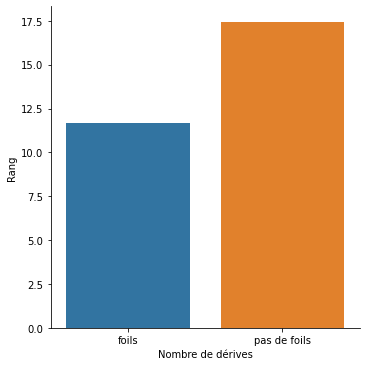

In [12]:
sns.catplot(data=df_merge, x="Nombre de dérives", y="Rang", kind="bar", ci=None)
plt.show()

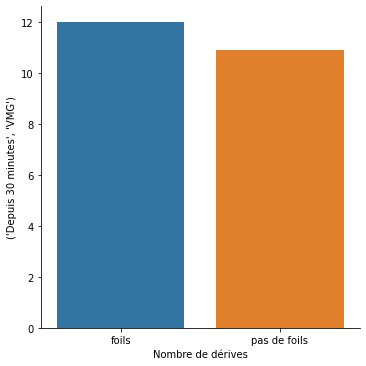

In [13]:
sns.catplot(data=df_merge, x="Nombre de dérives", y=('Depuis 30 minutes', 'VMG'), kind="bar", ci=None)
plt.show()

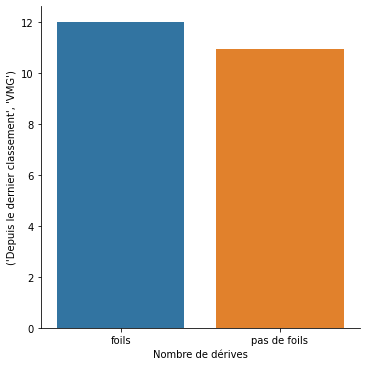

In [14]:
sns.catplot(data=df_merge, x="Nombre de dérives", y=("Depuis le dernier classement", "VMG"), kind="bar", ci=None)
plt.show()

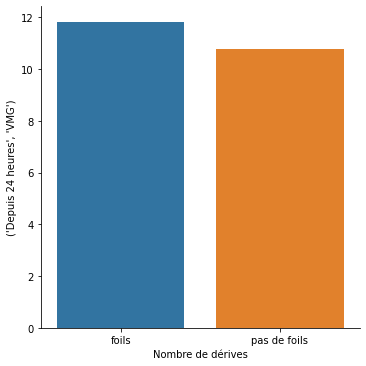

In [15]:
sns.catplot(data=df_merge, x="Nombre de dérives", y=("Depuis 24 heures", "VMG"), kind="bar", ci=None)
plt.show()

Conclusion : Il semble que la présence d'un foil a un impact sur le classement et la vitesse des voiliers.

### Impact de différents caractéristiques techniques des voiliers sur le classement

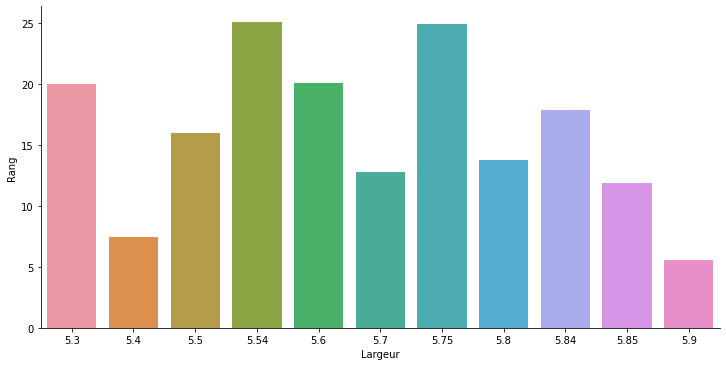

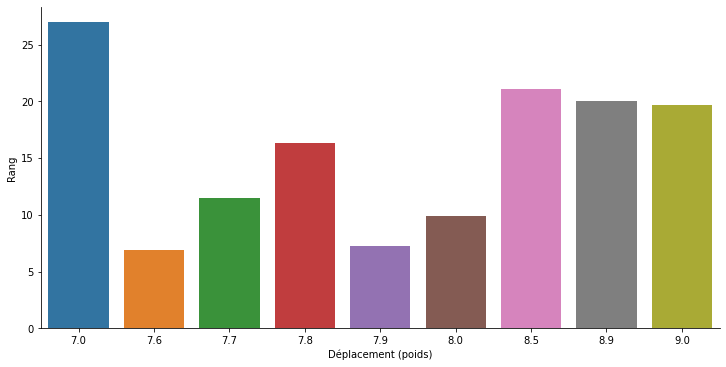

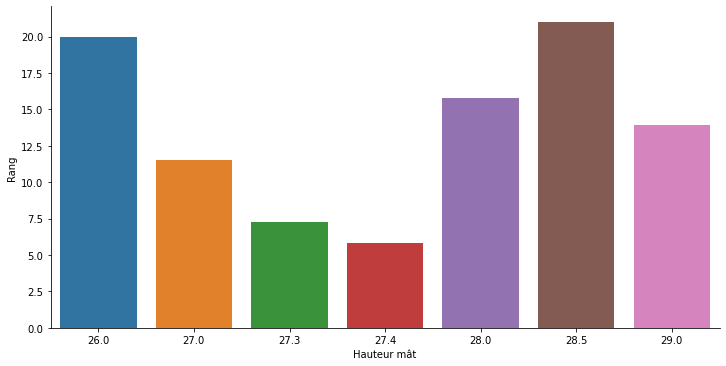

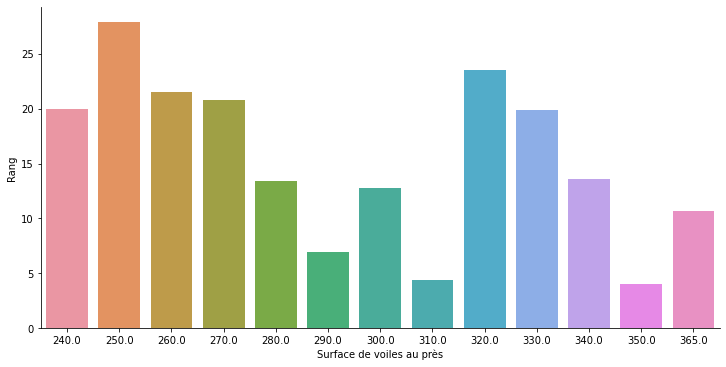

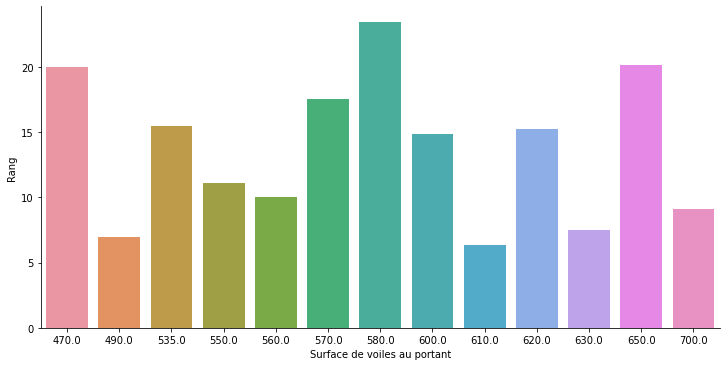

In [16]:
for col in ["Largeur","Déplacement (poids)","Hauteur mât","Surface de voiles au près","Surface de voiles au portant"]:
    sns.catplot(data=df_merge, x=col, y="Rang", kind="bar", aspect=2, ci=None)
    plt.show()

Conclusion : Il semble que les caractéristiques des voiliers ont un impact sur leur classement.

### Visualisation de la distance parcourue par voilier

In [17]:
df1 = df_merge.groupby(["Bateau",df_merge["time"].dt.date]).last()
df2 = pd.DataFrame()
df2["Bateau"] = df1.droplevel(1).index.unique().values
df2["Distance Parcourue"] = df1[('Depuis 24 heures', 'Distance')].sum(level=0).values

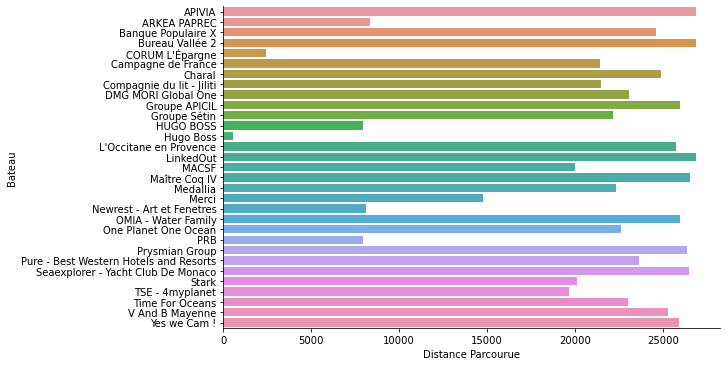

In [18]:
sns.catplot(data=df2, x="Distance Parcourue", y="Bateau", orient="h", kind="bar", aspect=2, ci=None)
plt.show()